This notebook describes the steps performed to create the product corresponding to the specific species defined by Olivier.

In [21]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

In [98]:
# Module where the output grid and the modules are defined
include("../src/emodnet_bio_grid.jl");
include("../src/make_benthos_products.jl");
include("../src/make_fishs_products.jl");

## Prepare the grid and the mask

In [3]:
# Grid stored in emodnet_bio_grid.jl
xi,yi = DIVAnd.ndgrid(gridlonBenthos, gridlatBenthos);

# Mask
topodir = "../data/"
topofile = joinpath(topodir, "gebco_30sec_8.nc");

if isfile(topofile)
    bx, by, b = DIVAnd.load_bath(topofile,true,gridlonBenthos, gridlatBenthos);
    xmask, ymask, mmask = DIVAnd.load_mask(topofile,true,gridlonBenthos, gridlatBenthos,[0]);
else
    @error "Bathymetry file doesn't exist"
end
mmask = mmask[:,:,1]
@info size(mmask)

# Metrics
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

┌ Info: (451, 371)
└ @ Main In[3]:15


In [14]:
function read_benthos_specific(filename::String)
    """
    Header:
    "sta","x","y","Arctica islandica","Spiophanes bombyx","Urothoe poseidonis"
    """
    data,header = readdlm(filename,',',header = true)
    header = header[:]

    obslon = Vector{Float64}(data[:,findfirst(header .== "x")]);
    obslat = Vector{Float64}(data[:,findfirst(header .== "y")]);

    stationname = Vector{String}(data[:,findfirst(header .== "sta")]);

    g1 = Vector{Float64}(data[:,findfirst(header .== "Arctica islandica")]);
    g2 = Vector{Float64}(data[:,findfirst(header .== "Spiophanes bombyx")]);
    g3 = Vector{Float64}(data[:,findfirst(header .== "Urothoe poseidonis")]);

    return obslon, obslat, g1, g2, g3
end

read_benthos_specific (generic function with 1 method)

### Read data

In [51]:
fname = joinpath(datadir, "Benthos-Specific/Benthos_Specific_cases.csv");
@info "Reading data file $(fname)"
obslon, obslat, g1, g2, g3 = read_benthos_specific(fname);
@info extrema(obslat)
@info extrema(obslon) 
@info extrema(gridlonBenthos)
@info extrema(gridlatBenthos) 

┌ Info: Reading data file /home/ctroupin/tmp/Emodnet-Bio/Benthos-Specific/Benthos_Specific_cases.csv
└ @ Main In[51]:2
┌ Info: (41.3894, 72.579834)
└ @ Main In[51]:4
┌ Info: (-9.39937, 34.328014)
└ @ Main In[51]:5
┌ Info: (-10.0, 35.0)
└ @ Main In[51]:6
┌ Info: (36.0, 73.0)
└ @ Main In[51]:7


## Parameter choice 
Chose via sensitivity analysis, as the optimisation tools provide too low values for L and noise-to-signal ratio.

In [16]:
# Correlation length
len = 2.;
# Observational error variance normalized by the background error variance
epsilon2 = 5.;

The weight is decreased for very close points.

In [17]:
rdiag=1.0./DIVAnd.weight_RtimesOne((obslon, obslat),(0.03,0.03))
@show maximum(rdiag),mean(rdiag);
epsilon2 = epsilon2*rdiag;

(maximum(rdiag), mean(rdiag)) = (439.41430043634097, 33.62322573600825)


## Perform analysis

In [54]:
@info "Interpolating"
fi1rel, fi2rel, fi3rel, totalfield = make_analysis(obslon, obslat, g1, g2, g3);
fi1abs, fi2abs, fi3abs = fi1rel .* totalfield, fi2rel .* totalfield, fi3rel .* totalfield;

┌ Info: Interpolating
└ @ Main In[54]:1


  1.509653 seconds (2.30 M allocations: 1.450 GiB, 39.34% gc time)
  1.674291 seconds (2.30 M allocations: 1.450 GiB, 39.06% gc time)
  1.617527 seconds (2.30 M allocations: 1.450 GiB, 40.01% gc time)


### Make plots
#### Data

In [105]:
function make_scatter_grid_specific(g1, g2, g3; vmin=0., vmax=1.0)
    figure("benthos_data", figsize=(12,8))
    ax1 = subplot(1,3,1)
    title("Arctica islandica", fontsize=8)
    #PyPlot.contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
    ax1[:tick_params]("both",labelsize=6)
    gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    scat1 = PyPlot.scatter(obslon, obslat, s=0.5, c=g1, vmin=vmin, vmax=vmax)
    gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    cb = colorbar(scat1, shrink=.5,extend="max")[:ax][:tick_params](labelsize=8)
    add_mask(bx, by, b)
    ax2 = subplot(1,3,2)
    title("Spiophanes bombyx", fontsize=8)
    #PyPlot.contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
    ax2[:tick_params]("both",labelsize=6)
    scat2 = PyPlot.scatter(obslon, obslat, s=0.5, c=g2, vmin=vmin, vmax=vmax)
    gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    colorbar(scat2, shrink=.5,extend="max")[:ax][:tick_params](labelsize=8)
    add_mask(bx, by, b)
    ax3 = subplot(1,3,3)
    title("Urothoe poseidonis", fontsize=8)
    #PyPlot.contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
    ax3[:tick_params]("both",labelsize=6)
    scat3 = PyPlot.scatter(obslon, obslat, s=0.5, c=g3, vmin=vmin, vmax=vmax)
    gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    colorbar(scat3,shrink=.5, extend="max")[:ax][:tick_params](labelsize=8)
    add_mask(bx, by, b)
end

make_scatter_grid_specific (generic function with 3 methods)

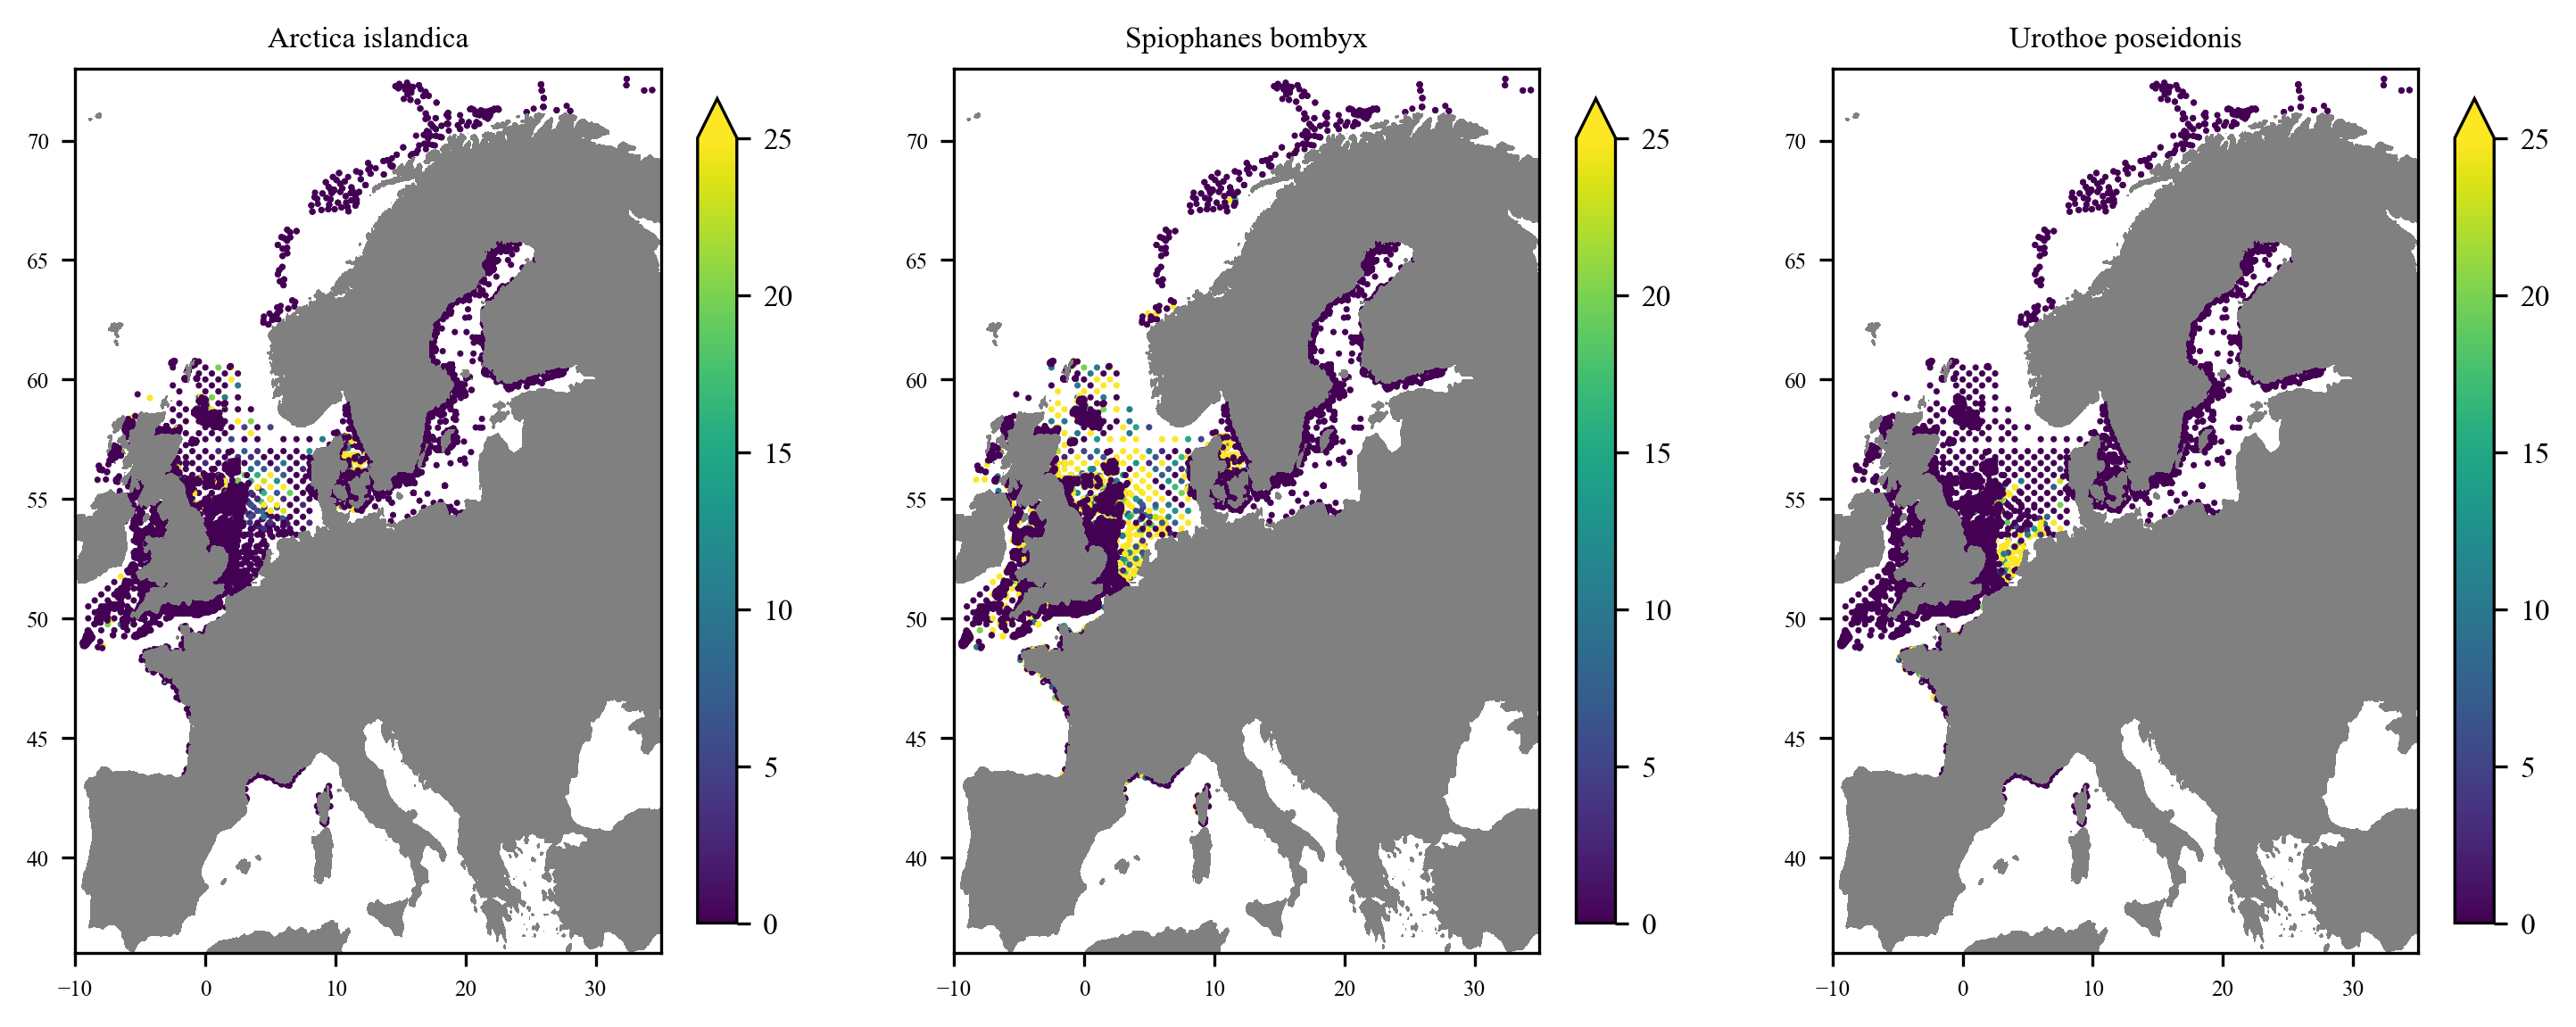

In [107]:
make_scatter_grid_specific(g1, g2, g3, vmin=0., vmax=25.)
PyPlot.savefig("../figures/Benthos_Specific_cases_data.png", dpi=300, bbox_inches="tight")

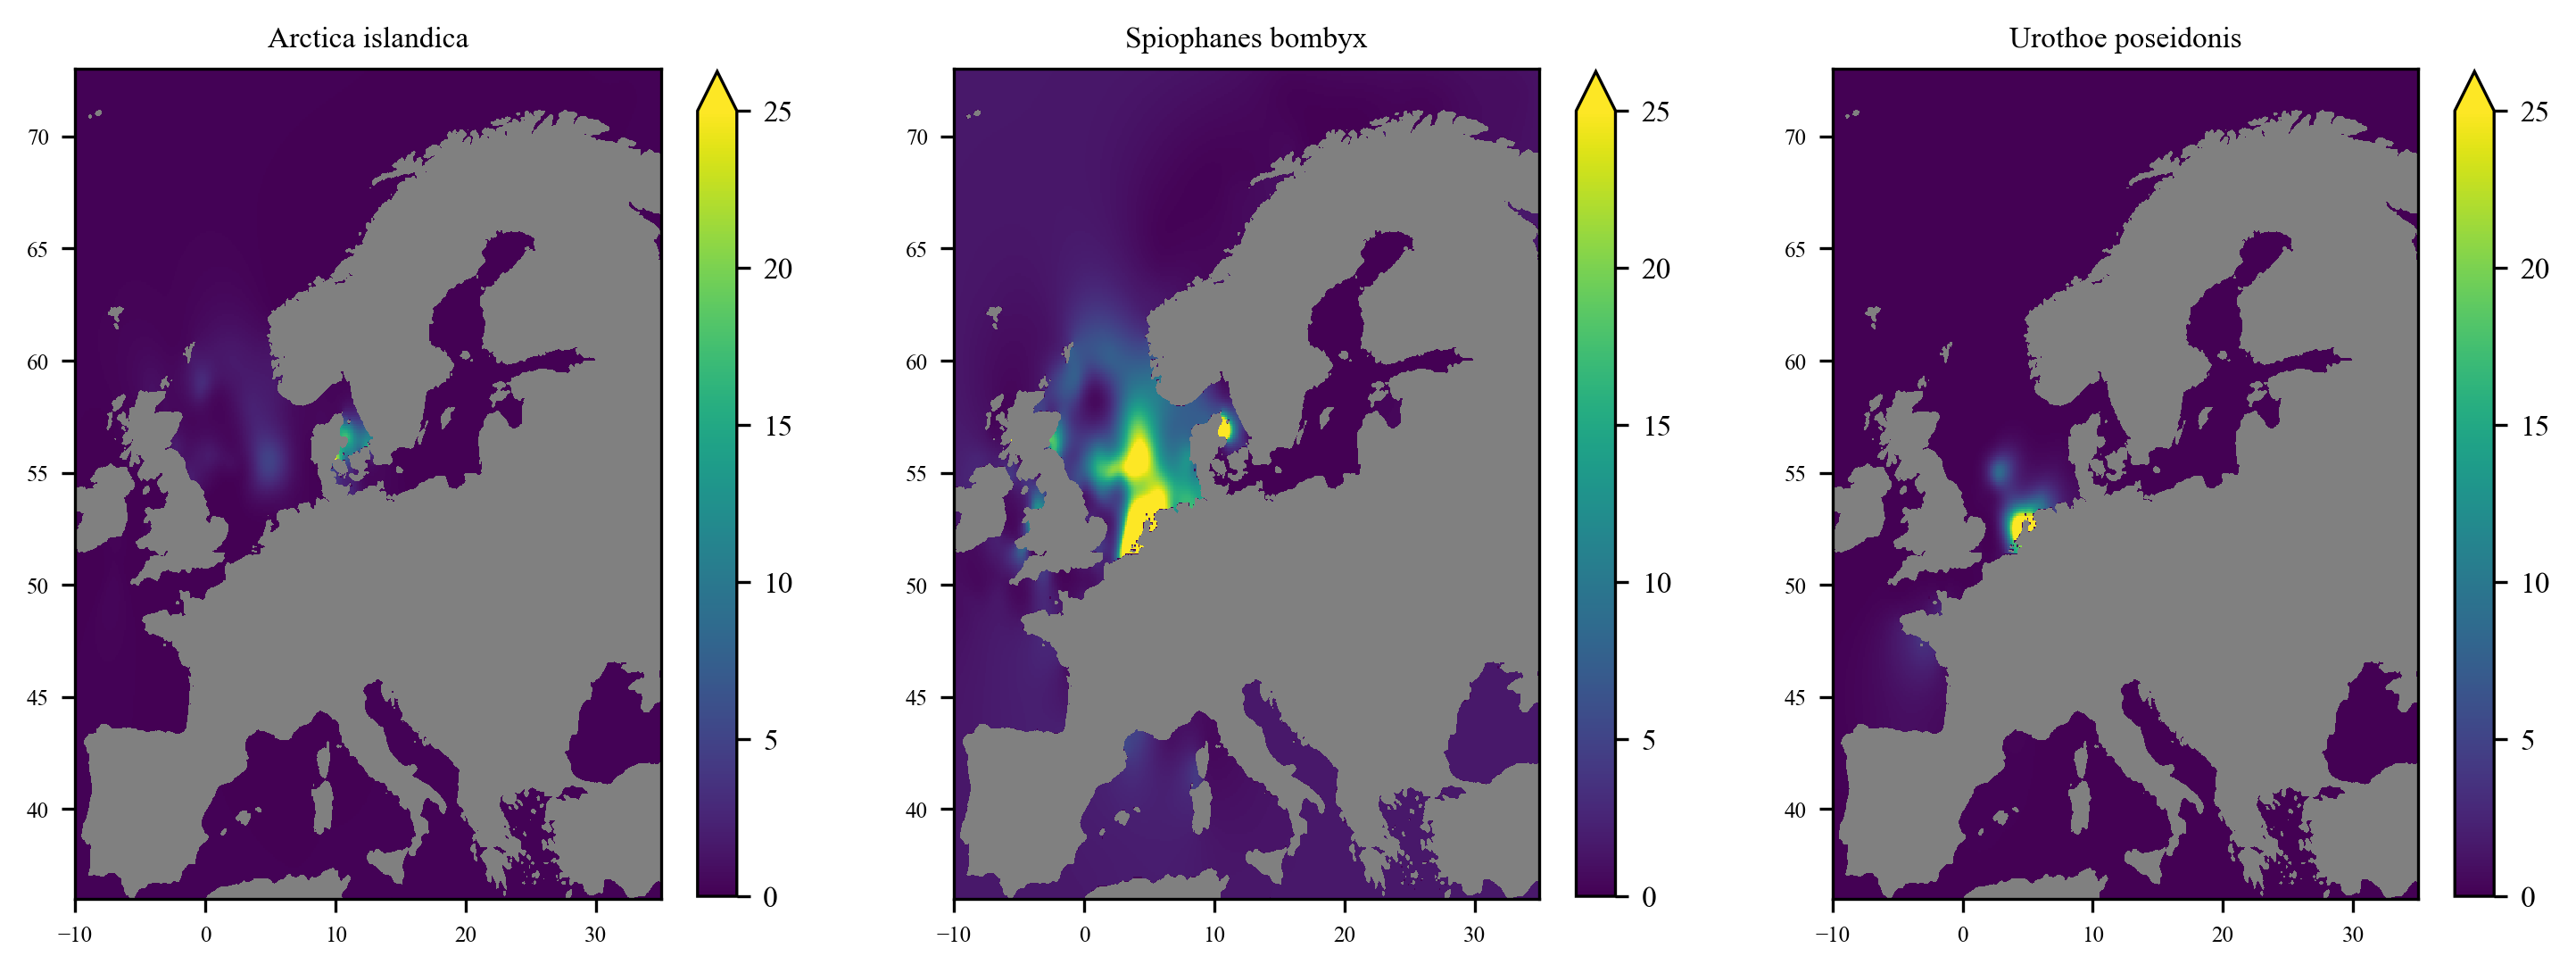

In [95]:
make_plot_grid_spec(fi1abs, fi2abs, fi3abs, vmin=0., vmax=25., shrink=0.5)
PyPlot.savefig(joinpath("../figures/Benthos_Specific_cases.png"), dpi=300, bbox_inches="tight")

## Error field
We use the so-called *Clever Poor Man's Estimate*.

In [81]:
g1_err, g2_err, g3_err = compute_error(obslon, obslat, g1, g2, g3);

### Make plot

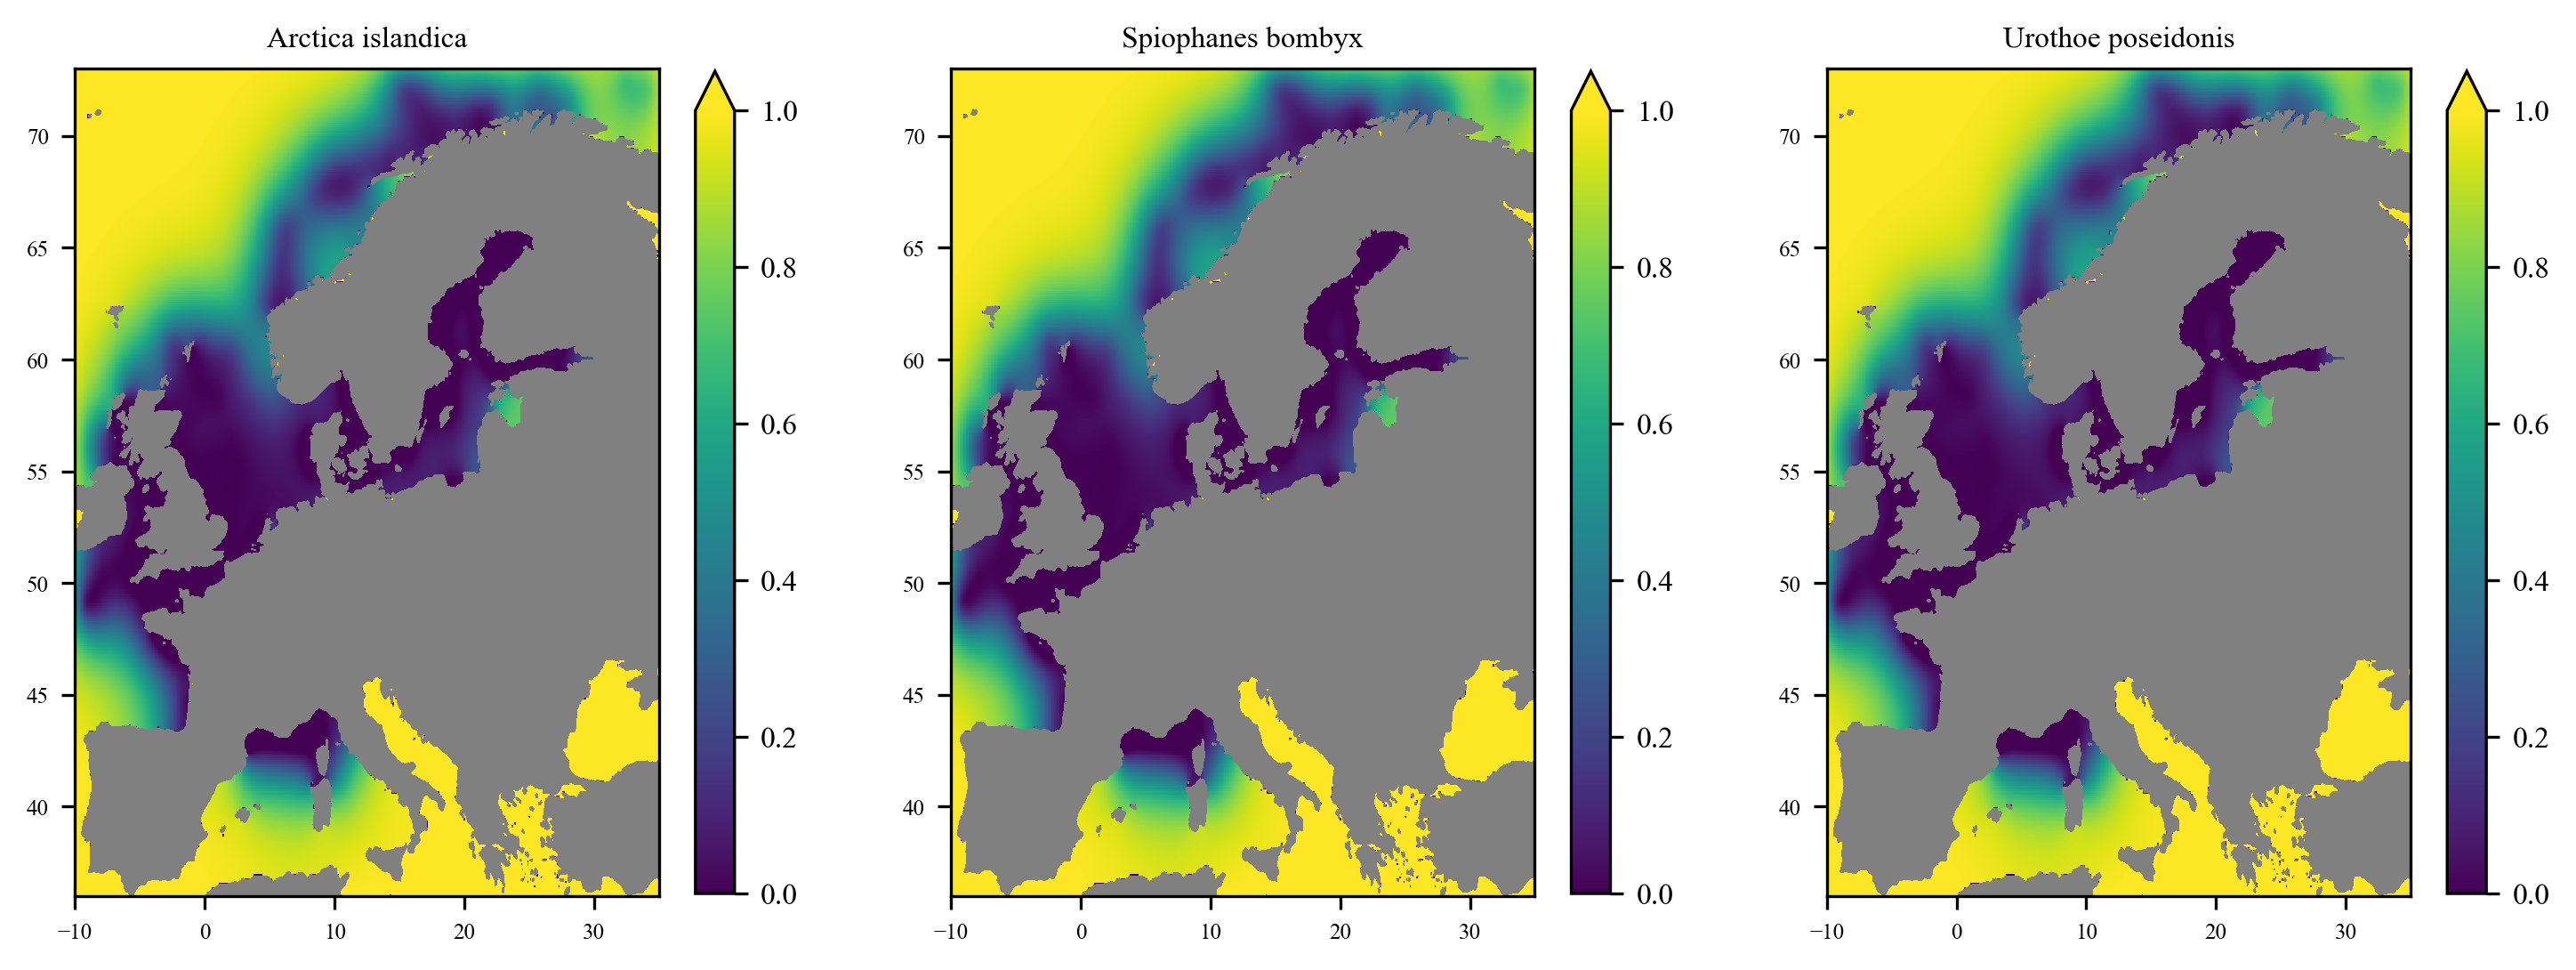

In [97]:
make_plot_grid_spec(g1_err, g2_err, g3_err, vmin=0, vmax=1., shrink=.5)
PyPlot.savefig("../figures/Benthos_Specific_cases_error.png", dpi=300, bbox_inches="tight")

## Write the results and the error field in a netCDF file
Create new output directory if necessary.

In [100]:
outputdir = "../output/"
if !isdir(outputdir)
    @info("Creating output directory $(outputdir)")
    mkdir(outputdir);
end
@info "Write netCDF"
write_benthos_nc(joinpath(outputdir, "Benthos_Specific_cases.nc"), gridlonBenthos, gridlatBenthos,
fi1abs, fi2abs, fi3abs, g1_err, g2_err, g3_err);

┌ Info: Write netCDF
└ @ Main In[100]:6
